In [5]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Creating a somewhat realistic sample information

In [114]:
import numpy as np
import random
from datetime import time

# Creating a somewhat realistic sample information

# User-specific information
distance_unit = 'Kilometer'
route_length = 42 # the length of the route back to the starting point
minimum_fare = 13 # the fare passengers pay for the first minimum_distance kilometers
minimum_distance = 4 # distances longer than this require additional payment
additional_charge_per_km = 1.50 # the fare passengers pay for each succeeding kilometer

# Number of passengers for the day
n = 16000

# We are assuming that the number of passengers is dominated by commuting workers and students going to and from work and school respectively
# Therefore, the boarding time distribution is bimodal centered around 0700 and 1700
mu_time, sigma_time = 7, 3.75
mu2_time, sigma2_time = 17, 4.01
normal_time = np.random.normal(mu_time, sigma_time, n // 2)
normal2_time = np.random.normal(mu2_time, sigma2_time, n // 2)

# We are assuming that most passengers come from densely populated areas, and the route starting and midway segments usually are
# Therefore, the boarding place distribution is bimodal centered around 1 and route_length / 2
mu_place, sigma_place = 1, 3.87
mu2_place, sigma2_place = route_length / 2, 4.31
normal_place = np.random.normal(mu_place, sigma_place, n // 2)
normal2_place = np.random.normal(mu2_place, sigma2_place, n // 2)

# Removing invalid values (Time is only between 0000 and 2400)
for i in range(len(normal_time)):
    if normal_time[i] < 0 or normal_time[i] > 24:
        normal_time[i] = mu_time

for i in range(len(normal2_time)):
    if normal2_time[i] < 0 or normal2_time[i] > 24:
        normal2_time[i] = mu2_time

# Removing invalid values (Place is only between 0 and 42)
for i in range(len(normal_place)):
    if normal_place[i] < 0:
        normal_place[i] += 2 * (mu_place - normal_place[i])
    if normal_place[i] > route_length:
        normal_place[i] -= 2 * (normal_place[i] - mu_place)

for i in range(len(normal2_place)):
    if normal2_place[i] < 0:
        normal2_place[i] += 2 * (mu2_place - normal2_place[i])
    if normal2_place[i] > route_length:
        normal2_place[i] -= 2 * (normal2_place[i] - mu2_place)

bimodal_time = np.concatenate([normal_time, normal2_time])
bimodal_place = np.concatenate([normal_place, normal2_place])

# Turning the random numbers into random time objects and adding them to a DataFrame
info_dict = {'boarding_time': [], 'boarding_place': [], 'boarding_payment': []}

for i in bimodal_time:
    hour = int(i)
    minute = random.randint(0, 59)
    second = random.randint(0, 59)
    info_dict['boarding_time'].append(time(hour, minute, second))

for i in bimodal_place:
    place = int(i)
    info_dict['boarding_place'].append(place)
    travel_distance = random.randint(0, route_length - place)
    if travel_distance <= minimum_distance:
        info_dict['boarding_payment'].append(minimum_fare)
    else:
        info_dict['boarding_payment'].append(minimum_fare + additional_charge_per_km * (travel_distance - minimum_distance))


df = pd.DataFrame(info_dict)


In [115]:
# A typical information sheet contains when passengers board, where passengers board, and how much passengers paid
df

,boarding_time,boarding_place,boarding_payment
0,12:53:23,2,31.0
1,03:01:36,5,44.5
2,08:56:09,0,22.0
3,07:50:51,4,53.5
4,13:22:00,1,37.0
...,...,...,...
15995,11:26:34,21,13.0
15996,12:55:18,20,26.5
15997,12:07:28,23,34.0
15998,21:46:00,21,22.0


In [122]:
# Cleaning up the data by sorting by boarding_time
df = df.sort_values('boarding_time')
df = df.reset_index()
df = df.drop('index', axis = 1)

# We do not need the exact time a passenger boards, just the hours
df['boarding_hour'] = df['boarding_time'].apply(lambda x: x.hour)

# Calculate how many passengers we get per kilometer-hour
passenger_distribution = df.pivot_table(index="boarding_hour", columns="boarding_place", aggfunc = 'size', fill_value=0)
passenger_distribution

boarding_place,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
boarding_hour,,,,,,,,,,,,,,,,,,,,,
0,25,19,40,22,30,21,20,13,9,4,...,0,0,0,0,0,0,0,0,0,0
1,30,29,67,49,32,28,32,12,12,11,...,0,0,0,0,0,0,0,0,0,0
2,43,55,72,67,51,51,27,21,9,7,...,0,0,0,0,0,0,0,0,0,0
3,51,43,104,93,63,55,52,21,17,6,...,0,0,0,0,0,0,0,0,0,0
4,65,66,116,114,85,62,51,35,20,13,...,1,1,0,0,0,0,0,0,0,0
5,94,87,168,138,116,87,58,45,28,10,...,0,0,0,0,0,0,0,0,0,0
6,92,77,161,123,96,92,70,39,26,18,...,1,0,0,0,0,0,0,0,0,0
7,116,112,229,186,135,110,76,53,39,24,...,2,1,0,0,0,0,0,0,0,0
8,71,70,135,143,100,95,69,39,21,12,...,3,1,0,0,0,0,1,0,0,0


In [123]:
# Calculate how much we earn per segment of kilometer per hour
income_distribution = df.pivot_table(index="boarding_hour", columns="boarding_place", values="boarding_payment", aggfunc = 'sum', fill_value=0)
income_distribution

boarding_place,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
boarding_hour,,,,,,,,,,,,,,,,,,,,,
0,857.5,689.5,1615.0,749.5,1078.5,768.0,653.0,536.5,286.5,104.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
1,1252.5,1055.0,2471.5,1849.0,1227.5,952.0,1169.0,354.0,486.0,440.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
2,1735.0,2077.0,2469.0,2218.0,1938.0,1833.0,897.0,718.5,301.5,254.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
3,2101.5,1511.5,4191.5,3385.5,2496.0,1751.5,1742.5,807.0,410.0,183.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
4,2523.5,2629.5,4439.0,3858.0,3103.0,2030.0,1878.0,1046.0,764.0,410.5,...,13.0,25.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
5,3551.5,3355.5,6214.5,5326.5,3968.0,3067.5,1777.0,1336.5,1072.0,316.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
6,3542.0,2834.0,6357.5,4315.5,3121.5,3243.5,2327.5,1303.5,956.0,537.0,...,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
7,4449.5,4370.5,8033.5,7206.0,4891.5,3906.5,2327.5,1673.0,1272.0,796.5,...,30.5,13.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
8,2799.5,2546.5,4905.0,5447.0,3598.0,3261.5,2451.0,1248.0,825.0,346.5,...,60.0,14.5,0.0,0.0,0.0,0.0,20.5,0,0.0,0


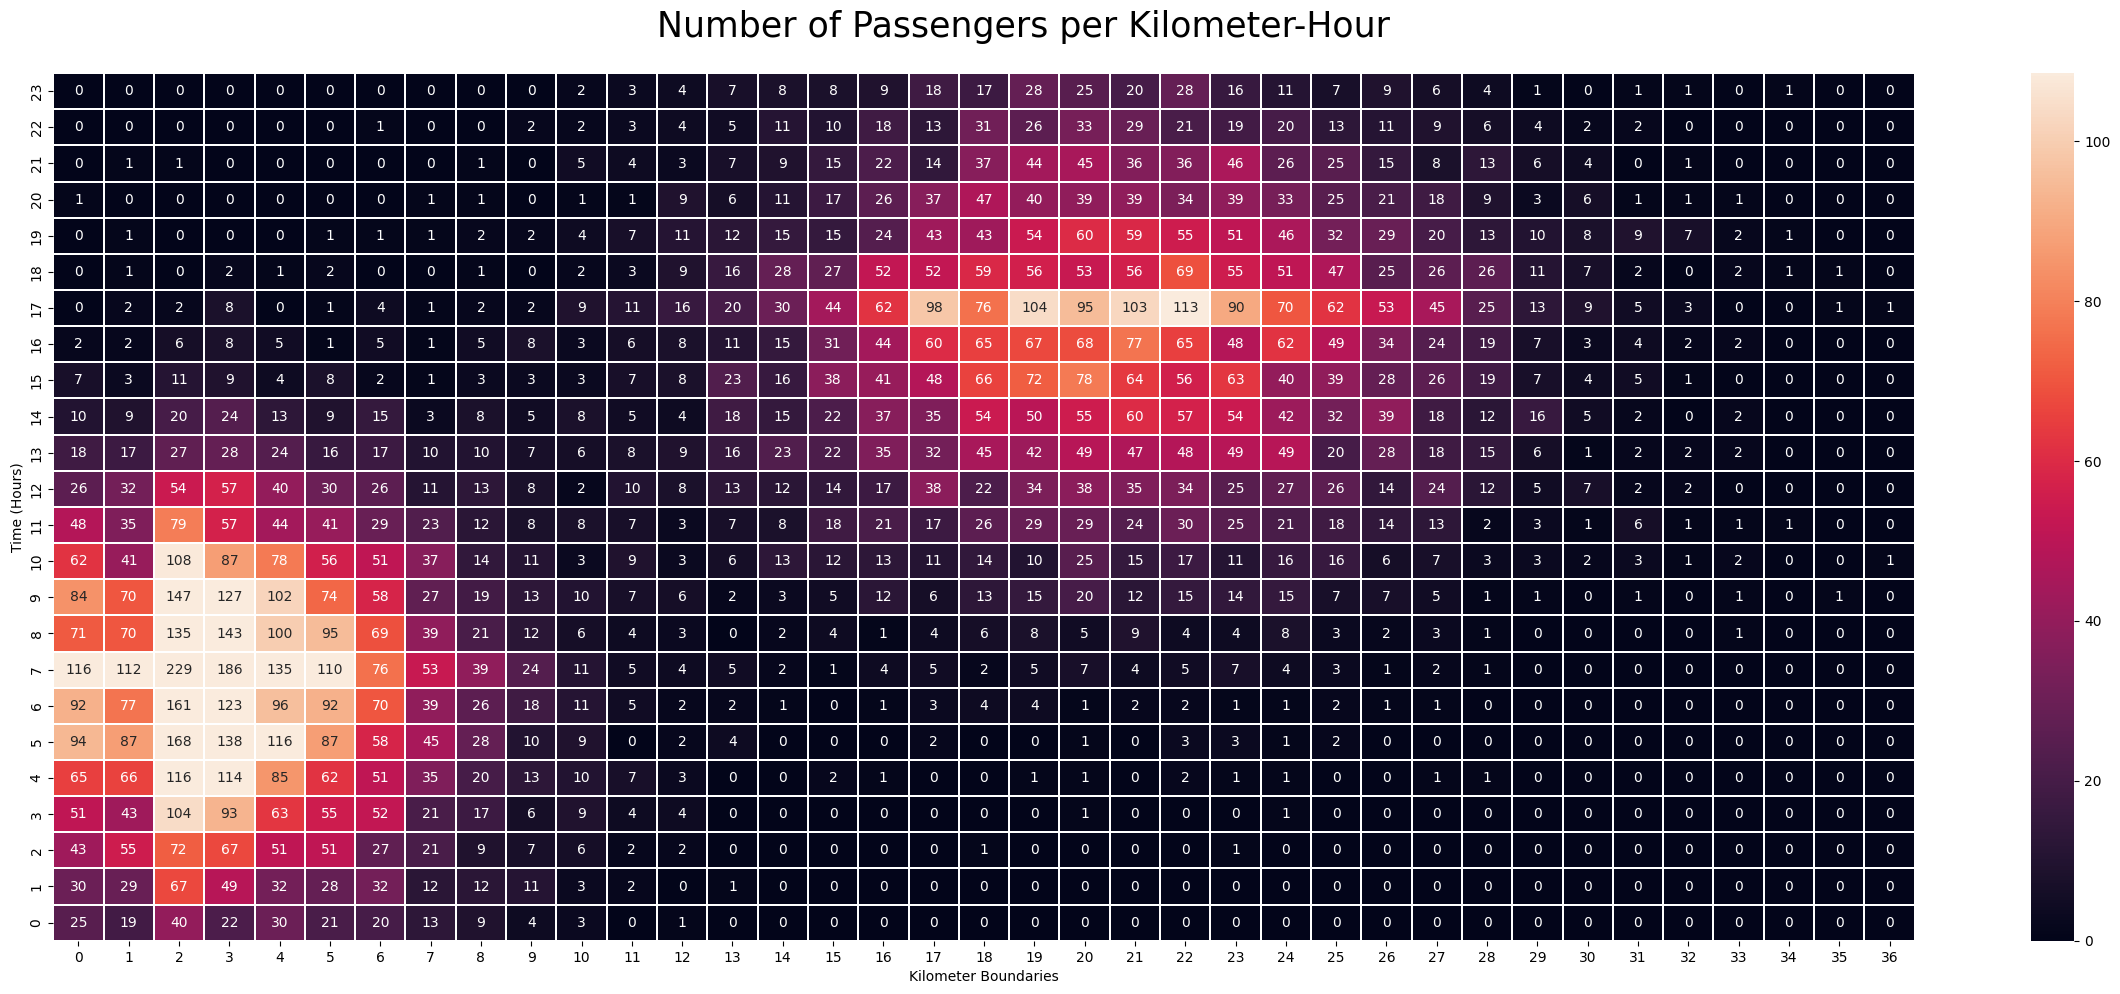

In [140]:
# Visualizing the passenger_distribution
fig, ax = plt.subplots(figsize=(24, 10))
sns.heatmap(passenger_distribution, annot = True, fmt = '1.0f', linewidths = 0.1, ax = ax, robust = True)
plt.xlabel(f'{distance_unit} Boundaries')
plt.ylabel('Time (Hours)')
plt.text(12, 25, f'Number of Passengers per {distance_unit}-Hour', fontsize = 25)
ax.invert_yaxis()
fig.tight_layout()

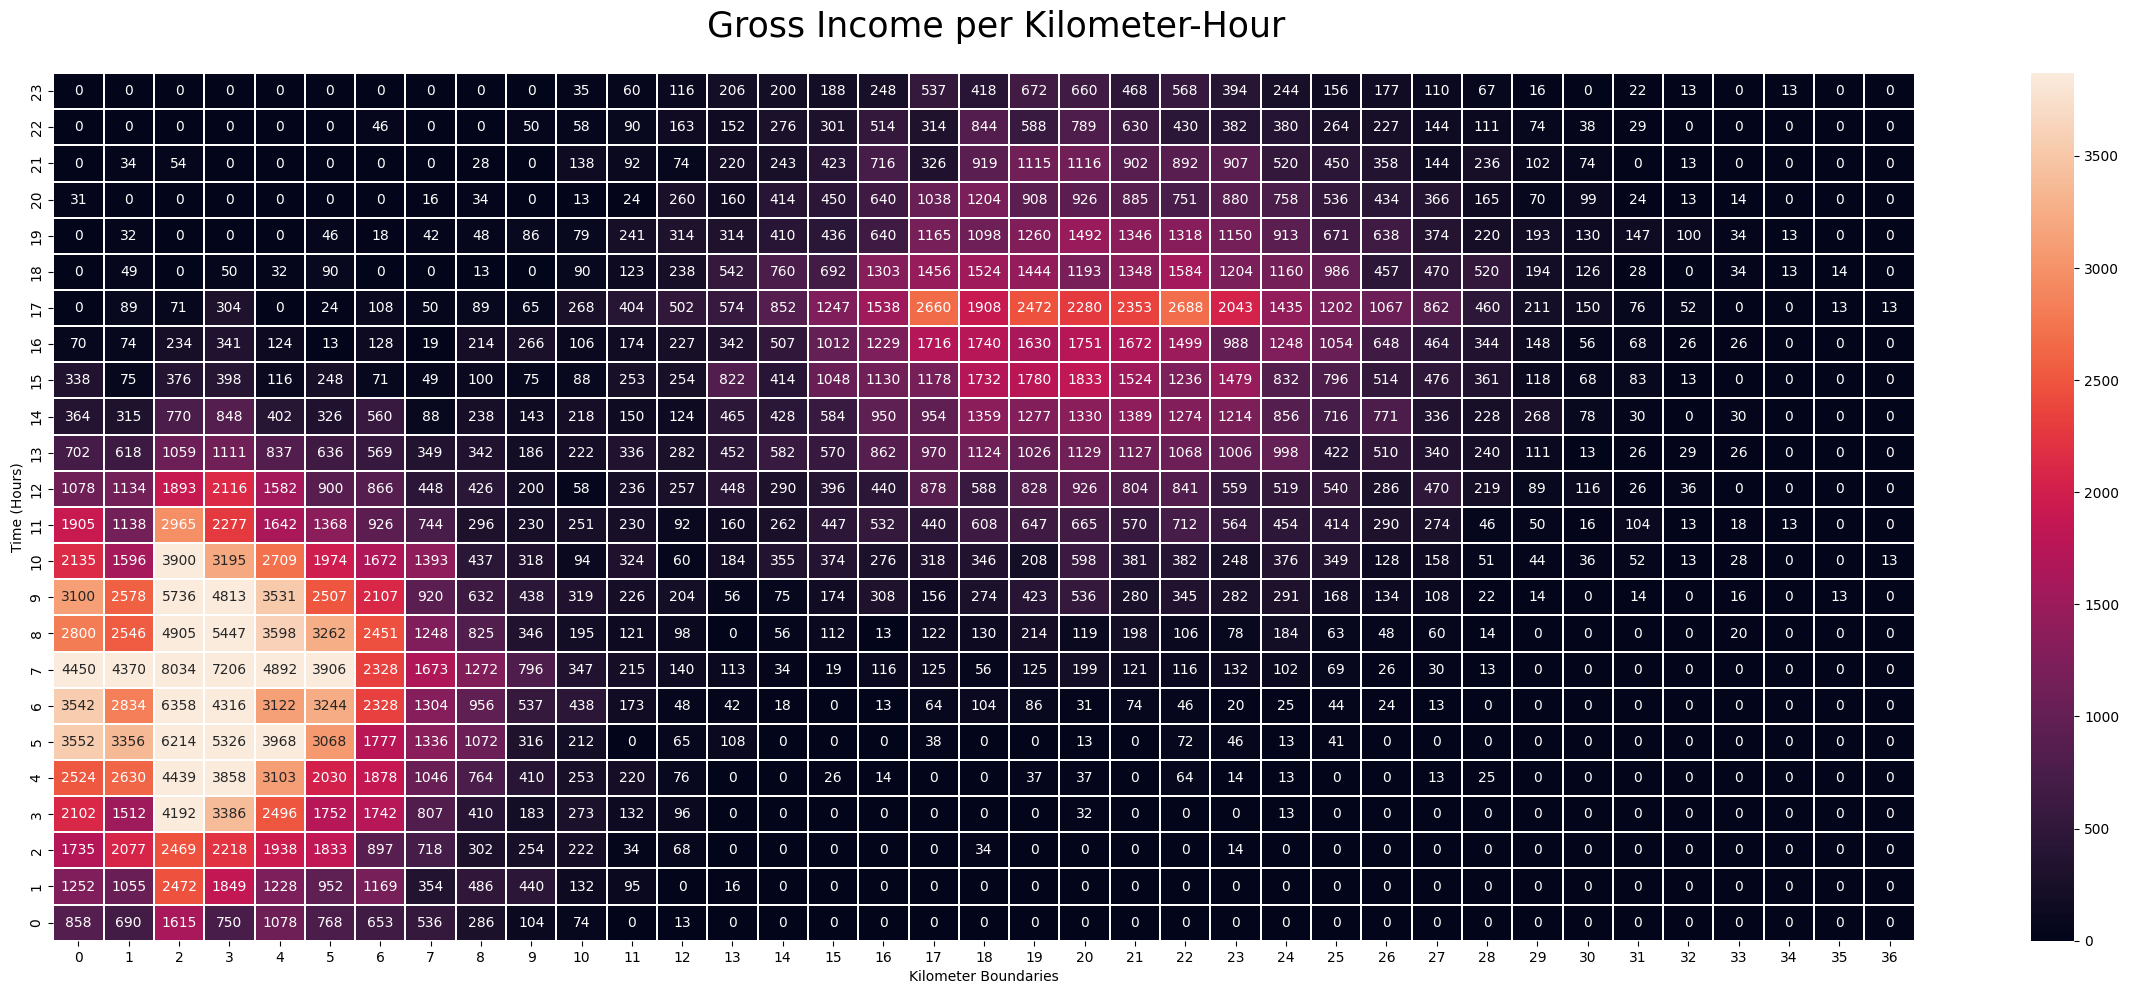

In [125]:
# Visualizing the income_distribution
fig, ax = plt.subplots(figsize=(24, 10))
sns.heatmap(income_distribution, annot = True, fmt = '1.0f', linewidths = 0.1, ax = ax, robust = True)
plt.xlabel(f'{distance_unit} Boundaries')
plt.ylabel('Time (Hours)')
plt.text(13, 25, f'Gross Income per {distance_unit}-Hour', fontsize = 25)
ax.invert_yaxis()
fig.tight_layout()

In [193]:
import math

# Calculating the minimum number of public utility vehicles needed to satisfy the demand by the hour

vehicle_capacity = 20 # Max capacity of a standard public utility vehicle

passenger_per_hour = passenger_distribution.T
passenger_per_hour.loc['Total Passengers'] = passenger_per_hour.sum()
minimum_vehicles = passenger_per_hour.loc['Total Passengers'].apply(lambda x: math.ceil(x / vehicle_capacity))
minimum_vehicles = minimum_vehicles.to_frame()
minimum_vehicles = minimum_vehicles.rename(columns = {'Total Passengers': 'Minimum Vehicles'})
minimum_vehicles

,Minimum Vehicles
boarding_hour,
0,11
1,16
2,21
3,27
4,33
5,43
6,42
7,58
8,42


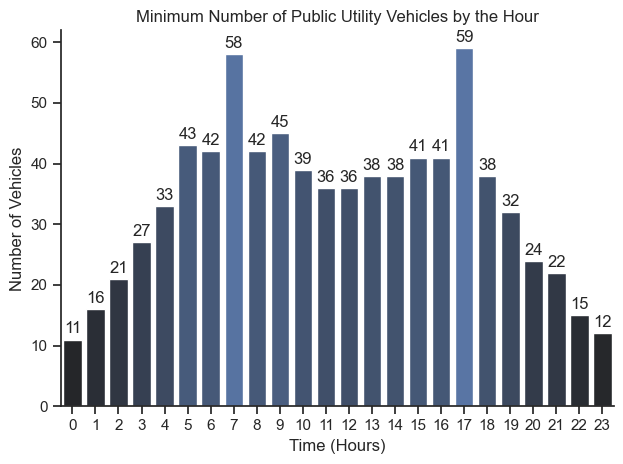

In [194]:
# Visualizing the minimum_vehicles
sns.set_theme(style = 'ticks')
sns.barplot(data = minimum_vehicles, x = minimum_vehicles.index, y = 'Minimum Vehicles', hue = 'Minimum Vehicles', palette = 'dark:b', legend = False)
sns.despine()
plt.xlabel('Time (Hours)')
plt.ylabel('Number of Vehicles')
plt.title('Minimum Number of Public Utility Vehicles by the Hour')

for i, value in enumerate(minimum_vehicles['Minimum Vehicles'].values.tolist()):
    plt.text(i, value + 1, value, ha = 'center')

plt.tight_layout()